# Tweet Text Emotion Classification with RoBerta

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../Lab2/emotion competition'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../Lab2/emotion competition\data_identification.csv
../Lab2/emotion competition\emotion.csv
../Lab2/emotion competition\sampleSubmission.csv
../Lab2/emotion competition\tweets_DM.json


---

# Import Module 

In [2]:
import numpy as np
import pandas as pd
import json

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---

# Tidying Files

**Read Files**

In [ ]:
emotion = pd.read_csv("../Lab2/emotion competition/emotion.csv")
data_identification = pd.read_csv("../Lab2/emotion competition/data_identification.csv")
tweets = pd.read_json("../Lab2/emotion competition/tweets_DM.json", lines=True)

**Seperate Training Data and Testing Data**

In this part, I use the pandas.merge function to match the ids with the tweets. 

In [ ]:
df = pd.merge(emotion, data_identification, how="outer")
df

,tweet_id,emotion,identification
0,0x3140b1,sadness,train
1,0x368b73,disgust,train
2,0x296183,anticipation,train
3,0x2bd6e1,joy,train
4,0x2ee1dd,anticipation,train
...,...,...,...
1867530,0x2c4dc2,NaN,test
1867531,0x31be7c,NaN,test
1867532,0x1ca58e,NaN,test
1867533,0x35c8ba,NaN,test


Use the groupby function to seperate train and test dataset

In [ ]:
train_df = df.groupby(df.identification).get_group("train")
test_df = df.groupby(df.identification).get_group("test")
print(f"train data:\n{train_df}\n\ntest data:\n{test_df}")

train data:
         tweet_id       emotion identification
0        0x3140b1       sadness          train
1        0x368b73       disgust          train
2        0x296183  anticipation          train
3        0x2bd6e1           joy          train
4        0x2ee1dd  anticipation          train
...           ...           ...            ...
1455558  0x38dba0           joy          train
1455559  0x300ea2           joy          train
1455560  0x360b99          fear          train
1455561  0x22eecf           joy          train
1455562  0x2fb282  anticipation          train

[1455563 rows x 3 columns]

test data:
         tweet_id emotion identification
1455563  0x28cc61     NaN           test
1455564  0x2db41f     NaN           test
1455565  0x2466f6     NaN           test
1455566  0x23f9e9     NaN           test
1455567  0x1fb4e1     NaN           test
...           ...     ...            ...
1867530  0x2c4dc2     NaN           test
1867531  0x31be7c     NaN           test
1867532  0x1ca5

In [ ]:
tweets = tweets.drop(['_index', '_crawldate', '_type'], axis=1)
tweets.head()

,_score,_source
0,391,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id..."
1,433,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg..."
2,232,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_..."
3,376,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5..."
4,989,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2..."


In [ ]:
tweet_id = []
text = []
for i in tweets._source:
    tweet_id.append(i['tweet']['tweet_id'])
    text.append(i['tweet']['text'])

tweets['tweet_id'] = pd.Series(tweet_id)
tweets['text'] = pd.Series(text)

In [ ]:
train_df = pd.merge(train_df, tweets).sample(frac=1)
train_df = train_df.drop(['_source','_score', 'identification'],axis=1)
train_df.head()

,tweet_id,emotion,text
1166041,0x324dc9,joy,<LH> <LH> A relationship where you can let you...
371981,0x2a65ac,fear,"I'm not a <LH> person, but this morning, it ha..."
811726,0x334534,sadness,I love being <LH> 🙃💔
160287,0x204f02,anger,Ppl in <LH> rlly make me #mad. Ur relationship...
1190261,0x2bb753,sadness,@realDonaldTrump Bet you’re getting sick of lo...


In [ ]:
test_df = pd.merge(test_df, tweets)
test_df = test_df.drop(['_source', '_score', 'identification'], axis=1)
test_df.head()

,tweet_id,emotion,text
0,0x28cc61,NaN,@Habbo I've seen two separate colours of the e...
1,0x2db41f,NaN,@FoxNews @KellyannePolls No serious self respe...
2,0x2466f6,NaN,"Looking for a new car, and it says 1 lady owne..."
3,0x23f9e9,NaN,@cineworld “only the brave” just out and fount...
4,0x1fb4e1,NaN,Felt like total dog 💩 going into open gym and ...


---

# Exploratory Data Analysis EDA 

In [ ]:
label = train_df.emotion.unique()
label

array(['joy', 'fear', 'sadness', 'anger', 'disgust', 'surprise',
       'anticipation', 'trust'], dtype=object)

In [ ]:
def plot_cloud(wordcloud, name):
    plt.figure(figsize=(10, 10))
    plt.title(name +' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

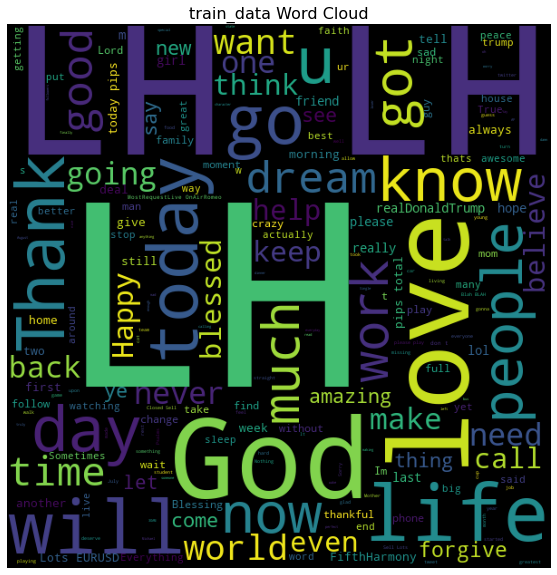

In [ ]:
temp_text = ' '.join([sentence for sentence in train_df.text])
wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
plot_cloud(wordcloud, 'train_data')

In [ ]:
temp_text = ' '.join([sentence for sentence in test_df.text])
wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
plot_cloud(wordcloud, 'train_data')

emotion
anger            15
anticipation     85
disgust          43
fear             27
joy             185
sadness          48
surprise         17
trust            80
Name: text, dtype: int64


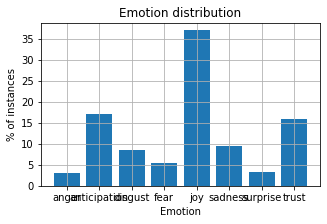

In [ ]:
df1 = train_df.groupby(['emotion']).count()['text']
print(df1)
# the histogram of the data
post_total = len(train_df)
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---

# Data Pre-processing

**Preprocessing includes:**

1. Removing stopwords (without removing negative words and remove lh)
2. Expand Contractions
3. Lemmatization

In [ ]:
def preprocess(sentence):
    #stop_words = set(stopwords.words('english')) # words we are ignoring
    lemmatizer = WordNetLemmatizer() # we can use lemmatizer to restore words into word on dictionary
    sentence = re.sub('[^A-z]', ' ', sentence) #remove word not english letters
    #negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
    #                     'even though', 'yet']
    #stop_words = [z for z in stop_words if z not in negative] # negative words should be counted
    stop_words = []
    stop_words.append('LH') #found a lot of lh as html tags
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))

As class imbalanced is evident, which we found in EDA that the "joy" is too much and imbalence, RandomOverSampler is used to add data(repetition) to all classes except highest frequency class.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_df['text']).reshape(-1, 1), np.array(train_df['emotion']).reshape(-1, 1))
train_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])
train_df

,text,emotion
0,the believer life in the power might of who li...,anticipation
1,philoscripts good to connect thank you for fol...,trust
2,wow edsheeran s made the biggest jump of the w...,joy
3,i wonder who wa behind kicking matthew off dis...,sadness
4,hug kid,joy
...,...,...
1475,having a plan make dealing with pressure easy_...,trust
1476,so glad my chosen family is full of genuinely ...,trust
1477,so glad my chosen family is full of genuinely ...,trust
1478,polishing off my prepped meal with an ice cold...,trust


---

# Encoding

Encoding Text

In [ ]:
from transformers import RobertaTokenizerFast
#from transformers import BertTokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In this part I spend pretty much time on it because:
1. the max_length parameters works with a lot of bugs which not always cut sentences length to the exactly I set to. So I can't convert the list to an array. At the end, I wrote a function "cut" for it to cut the sentences precisely.
2. when the max_length is too large, the RAM will exploded and needs lots of time to process, so I set the max_len to 50.

In [ ]:
max_len = 50 #cutting the length of sentences
sentences = train_df.text.values
#input_ids is give the words its ids
#attention masks set the words with ids to 1 and other blank space to 0
input_ids = [tokenizer.encode_plus(sent, add_special_tokens=True,max_length=max_len,padding='max_length')['input_ids'] for sent in sentences]
attention_masks = [tokenizer.encode_plus(sent, add_special_tokens=True,max_length=max_len,padding='max_length')['attention_mask'] for sent in sentences]

In [ ]:
#cutting test data to max len
def cut(inp, maxlen):
    for i in range(len(inp)):
        if len(inp[i]) > maxlen:
            inp[i] = inp[i][:maxlen]
    return inp

In [ ]:
input_ids = cut(input_ids, max_len)
attention_masks = cut(attention_masks, max_len)

In [ ]:
print("Actual sentence before tokenization: ",sentences[3])
print("Encoded Input from dataset: ",input_ids[3])
print("Attention Mask:",attention_masks[3])

Actual sentence before tokenization:  i wonder who wa behind kicking matthew off disappointed foodnetworkstar
Encoded Input from dataset:  [0, 118, 5170, 54, 13332, 639, 10720, 28648, 16152, 160, 5779, 689, 34728, 3641, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Encoding emotions

In [ ]:
labels = train_df.emotion.values
train_inputs,validation_inputs,train_labels,validation_labels= train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks, validation_masks,_,_=train_test_split(attention_masks, input_ids, random_state=41, test_size=0.1)

#Make the list into array which can fit to the model we are using
train_inputs=np.asarray(train_inputs)
validation_inputs=np.asarray(validation_inputs)
train_masks=np.asarray(train_masks)
validation_masks=np.asarray(validation_masks)

In [ ]:
#Encode emotions with one hot encoder
from sklearn import preprocessing
le = preprocessing.OneHotEncoder() 
y_train = le.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()
y_val = le.fit_transform(np.array(validation_labels).reshape(-1, 1)).toarray()

---

## Applying Model

In [ ]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base',
                                                  output_attentions=False,
                                                  return_dict=False,
                                                  output_hidden_states=False,
                                                  use_cache=False
                                                  )

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
label_len = len(label)
def create_model(bert_model, max_len, label_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(label_len, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=2e-5,epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = create_model(roberta_model, max_len, label_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  ((None, 50, 768),   124645632   ['input_1[0][0]',                
 odel)                           (None, 768))                     'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 8)            6152        ['tf_roberta_model_4[0][1]'] 

In this part, the problems are:
1. Because their are a lot of datas, so the computer training each epochs very slow, until I apply the GPU to this project.
2. If there is only 4 epochs the accuracy rate will be like only 0.7, so I set the epochs to 10.
3. Before I added RandomOverSample the accuracy are great but the val accuracy are like 0.4. But After I added it, the accuracy rate increased a lot and the val_accuracy is very close to accuracy rate.

In [ ]:
history = model.fit([train_inputs,train_masks], y_train, validation_data=([validation_inputs,validation_masks], y_val), epochs=8, batch_size=128)
print("training finish")

NameError: name 'model' is not defined

# Accuracy and Loss

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

---

# Predict Test data

Here, we did the pre-processing and encoding stuffs same as we done to training data.

In [ ]:
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

test_sentences = test_df.text.values
test_inputs = [tokenizer.encode_plus(sent, add_special_tokens=True,max_length=max_len,padding='max_length')['input_ids'] for sent in test_sentences]
test_masks = [tokenizer.encode_plus(sent, add_special_tokens=True,max_length=max_len,padding='max_length')['attention_mask'] for sent in test_sentences]

#cutting test data to max len
def cut(inp, maxlen):
    for i in range(len(inp)):
        if len(inp[i]) > maxlen:
            inp[i] = inp[i][:maxlen]
    return inp

test_inputs = cut(test_inputs, max_len)
test_masks = cut(test_masks, max_len)

# m = 0
# for i in range(len(test_masks)):
#     if len(test_masks[i]) > m:
#         m = len(test_masks[i])
# print(m)

test_inputs = np.asarray(test_inputs)
test_masks = np.asarray(test_masks)

We predict the model and result as a (,8) array which can be decoded into emotions.
Also, the prediction takes me like half of hours everytime with GPUs help...

In [ ]:
result = model.predict([test_inputs,test_masks])
print('result finish')

In [ ]:
result[:5]

Because onehotencode is not available to use the decoding method with inverse_transform (the problem might be the shape of the data), and I spend a lot of times to fix it ,but it still not work. 
At the end, I use the argmax method for my result data, which can transform it to label encoder with int 1~8. 


In [ ]:
result.argmax(1)[:5]

**Decoding Result**

Then, I use the label encoders classes to decode the onehot encode

In [ ]:
#onehotencode is not available so we did the decoding in another way
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df['emotion'])
label_encoder.classes_

In [ ]:
emo = []
for i in result.argmax(1):
    emo.append(label_encoder.classes_[i])
emo[:5]

In [ ]:
test_df['emotion'] = pd.Series(emo)
ans_df = test_df.drop(['text'], axis=1)
ans_df.rename(columns={'tweet_id':'id'},inplace=True)
ans_df.to_csv('submission.csv', encoding='utf-8', index=False)
ans_df

**Saving the logs**

In [ ]:
#model.save_weights('my_checkpoint') file to large


---

# Conclusion

The val_accuracy is very high even close to 1, but the test data accuracy is very low, which is           **overfitting**. I'm still trying to figure out the problem...

### Learned from this project:
1. **Memory matters.** Don't produce too many unuse array because python can't free memory.
2. **Running time matters.** We can use small data to run the code to check if the code can run well. Or, we will spend lots of time waiting.
3. **The type of data matters.** If we have the wrong data type, we can't fit the data into the models. Especially list and numpy array, because if the length of the lists are not equal, it can't be transform into a numpy array with shape.
4. **GPU is very helpful.** If we just use CPU to run the epochs, we will spend like a day, but GPU can handle it well.
5. **Class Imbalance matters.** After I added randomoversample, the accuracy rate increased a lot.